# Binary Classification with DNS and Combined Dataset

We will now use NTLK (the natural language toolkit) to process just the DNS Records.  This time though, we will import these from both the dataset from the paper for the 24hr-period as well as our own.

In [1]:
from pathlib import Path
import os
import re
import apsw
import pandas as pd
import time


In [2]:
cwd = Path.cwd().parent.parent
print(cwd)

/home/ricdeez/uni/projects/iotnetlearn


In [3]:
dbs = [
    os.path.join(cwd, 'db', 'db01', 'NetCollector.sqlite'),
    os.path.join(cwd, 'db', 'db02', 'NetCollector.sqlite'),
    os.path.join(cwd, 'db', 'db03', 'NetCollector.sqlite'),
]

In [4]:
from sqlalchemy import create_engine
df1 = None
df2 = None
df3 = None
for idx, db_path in enumerate(dbs):
    engine = create_engine(f'sqlite:////{db_path}')

    print(engine)

    sql = """

    select d.srcPort as srcport, 
           d.dstPort as dstport, 
           sum(d.frameSize) as totalframesize, 
           min(d.frameSize) as minframesize,
           max(d.frameSize) as maxframesize,
           avg(d.frameTTL) as framettl,
           dns.dnsquery,
           d.manufacturer,
           d.device_type
    from deviceLog d inner join dnsqueries dns on d.frameNum = dns.pktnum
    where d.device_type is not null
    group by d.srcAddr, d.dstAddr, d.srcPort, d.dstPort

    """

    if idx == 0:
        df1 = pd.read_sql_query(sql, engine)
    elif idx == 1:
        df2 = pd.read_sql_query(sql, engine)
    elif idx == 2:
        df3 = pd.read_sql_query(sql, engine)



Engine(sqlite://///home/ricdeez/uni/projects/iotnetlearn/db/db01/NetCollector.sqlite)
Engine(sqlite://///home/ricdeez/uni/projects/iotnetlearn/db/db02/NetCollector.sqlite)
Engine(sqlite://///home/ricdeez/uni/projects/iotnetlearn/db/db03/NetCollector.sqlite)


In [5]:
df1 = pd.concat([df1, df2], axis='rows', ignore_index=True)
df1 = pd.concat([df1, df3], axis='rows', ignore_index=True)
df = df1
df.describe()

,totalframesize,minframesize,maxframesize,framettl
count,32799.000000,32799.000000,32799.000000,32799.000000
mean,164.587701,84.173207,85.463063,92.856752
std,3267.692046,8.832032,9.917332,48.956212
min,65.000000,65.000000,65.000000,1.000000
25%,81.000000,78.000000,78.000000,64.000000
50%,91.000000,81.000000,81.000000,64.000000
75%,146.000000,91.000000,93.000000,128.000000
max,481258.000000,182.000000,366.000000,255.000000


In [6]:
import pandas_profiling
pandas_profiling.ProfileReport(df)

In [7]:
from keras.preprocessing.text import Tokenizer


Using TensorFlow backend.


In [8]:
dns = df['dnsquery']
dns

0                                  _googlecast._tcp.local.
1        chromecast-audio-46eabec7bd7a728a79fb6231c4ae5...
2        _00000000-06a1-86ad-4c60-2ffbf090480e._sub._ho...
3                                 _sleep-proxy._udp.local.
4                                 _sleep-proxy._udp.local.
                               ...                        
32794                             www.samsungsmartcam.com.
32795                             www.samsungsmartcam.com.
32796                             www.samsungsmartcam.com.
32797                                      smtp.gmail.com.
32798                                          google.com.
Name: dnsquery, Length: 32799, dtype: object

In [9]:
tk = Tokenizer()
tk.fit_on_texts(dns)
# https://github.com/keras-team/keras/issues/8092
num_words = 200
tk.word_index = {e:i for e,i in tk.word_index.items() if i < num_words} 

In [10]:
encoded_dns=tk.texts_to_matrix(dns, mode='binary')
encoded_dns.shape

(32799, 200)

In [11]:
cols = [f'word_idx{i+1}' for i in range(num_words)]
cols

['word_idx1',
 'word_idx2',
 'word_idx3',
 'word_idx4',
 'word_idx5',
 'word_idx6',
 'word_idx7',
 'word_idx8',
 'word_idx9',
 'word_idx10',
 'word_idx11',
 'word_idx12',
 'word_idx13',
 'word_idx14',
 'word_idx15',
 'word_idx16',
 'word_idx17',
 'word_idx18',
 'word_idx19',
 'word_idx20',
 'word_idx21',
 'word_idx22',
 'word_idx23',
 'word_idx24',
 'word_idx25',
 'word_idx26',
 'word_idx27',
 'word_idx28',
 'word_idx29',
 'word_idx30',
 'word_idx31',
 'word_idx32',
 'word_idx33',
 'word_idx34',
 'word_idx35',
 'word_idx36',
 'word_idx37',
 'word_idx38',
 'word_idx39',
 'word_idx40',
 'word_idx41',
 'word_idx42',
 'word_idx43',
 'word_idx44',
 'word_idx45',
 'word_idx46',
 'word_idx47',
 'word_idx48',
 'word_idx49',
 'word_idx50',
 'word_idx51',
 'word_idx52',
 'word_idx53',
 'word_idx54',
 'word_idx55',
 'word_idx56',
 'word_idx57',
 'word_idx58',
 'word_idx59',
 'word_idx60',
 'word_idx61',
 'word_idx62',
 'word_idx63',
 'word_idx64',
 'word_idx65',
 'word_idx66',
 'word_idx67',
 'wo

In [12]:
df2 = pd.DataFrame(data=encoded_dns, columns=cols)

In [13]:
df = pd.concat([df, df2], axis='columns')

In [14]:
df

,srcport,dstport,totalframesize,minframesize,maxframesize,framettl,dnsquery,manufacturer,device_type,word_idx1,...,word_idx191,word_idx192,word_idx193,word_idx194,word_idx195,word_idx196,word_idx197,word_idx198,word_idx199,word_idx200
0,5353,5353,13758,70,82,1.000000,_googlecast._tcp.local.,Rivet Networks,Other,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5353,5353,481258,82,132,255.000000,chromecast-audio-46eabec7bd7a728a79fb6231c4ae5...,"Google, Inc.",Chromecast-Audio,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5353,5353,1891,120,127,255.000000,_00000000-06a1-86ad-4c60-2ffbf090480e._sub._ho...,"Apple, Inc.",Apple TV,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5353,5353,882,104,190,255.000000,_sleep-proxy._udp.local.,"Apple, Inc.",Other,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5353,5353,8755,74,190,250.637931,_sleep-proxy._udp.local.,"Apple, Inc.",Other,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32794,60121,53,83,83,83,64.000000,www.samsungsmartcam.com.,"Samsung Electronics Co.,Ltd",Samsung SmartCam,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32795,60214,53,83,83,83,64.000000,www.samsungsmartcam.com.,"Samsung Electronics Co.,Ltd",Samsung SmartCam,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32796,60256,53,166,83,83,64.000000,www.samsungsmartcam.com.,"Samsung Electronics Co.,Ltd",Samsung SmartCam,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32797,60689,53,148,74,74,64.000000,smtp.gmail.com.,"Samsung Electronics Co.,Ltd",Samsung SmartCam,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
import numpy as np

df['is_iot'] = np.where(df['device_type'] == 'Other', 0, 1)
ports = ['53', '5353', '443', '5000', '49152', '80', '8080', '123', '49153']
features = ['dstport', 'srcport']
for feature in features:
    for port in ports:
        exec('df[\'{}_is_{}\'] = np.where(df[\'{}\'] == \'{}\', 1, 0)'.format(
                feature, port, feature, port))


In [16]:
drop_columns = ['srcport', 'dstport', 'device_type']

In [17]:
df.drop(drop_columns, axis='columns', inplace=True)

In [18]:
df.drop('dnsquery', axis='columns', inplace=True)

In [19]:
mapping = {k: v for v, k in enumerate((x for x in df['manufacturer'].unique() if len(x)>0),1)}
print(mapping)

{'Rivet Networks': 1, 'Google, Inc.': 2, 'Apple, Inc.': 3, 'Technicolor CH USA Inc.': 4, 'Microsoft Corporation': 5, 'Intel Corporate': 6, 'Realtek Semiconductor Corp.': 7, 'Pegatron Corporation': 8, 'Ubiquiti Networks Inc.': 9, 'Sony Corporation': 10, 'ASUSTek COMPUTER INC.': 11, 'Microsoft': 12, 'Samsung Electro-Mechanics(Thailand)': 13, 'Netatmo': 14, 'Lifi Labs Management Pty Ltd': 15, 'Invoxia': 16, 'Withings': 17, 'Shenzhen Reecam Tech.Ltd.': 18, 'Belkin International Inc.': 19, 'Physical Graph Corporation': 20, 'AzureWave Technology Inc.': 21, 'Samsung Electronics Co.,Ltd': 22, 'Amazon Technologies Inc.': 23, 'HTC Corporation': 24}


**Categorical data mapping**

For the deep learning algorithm to work, we need to get rid of all categorical data.  For the Manufacturer's we will create a 1:1 mapping of the manufacturer name as per the wireshark OUI lookup dataset and the relative
position of that in our ordered array of unique entries

In [20]:
df['manufacturer'] = df['manufacturer'].map(mapping)

In [21]:
df.head()

,totalframesize,minframesize,maxframesize,framettl,manufacturer,word_idx1,word_idx2,word_idx3,word_idx4,word_idx5,...,dstport_is_49153,srcport_is_53,srcport_is_5353,srcport_is_443,srcport_is_5000,srcport_is_49152,srcport_is_80,srcport_is_8080,srcport_is_123,srcport_is_49153
0,13758,70,82,1.000000,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,481258,82,132,255.000000,2,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1891,120,127,255.000000,3,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,882,104,190,255.000000,3,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,8755,74,190,250.637931,3,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


\begin{align}
\dot{x\tiny{i}} & = \frac{x\tiny{i} \small- min(X)}{max(X) - min(X)} \Large{\forall} \normalsize{x}\tiny{i} \small\in X
\end{align}

In [22]:
features = ['totalframesize', 'minframesize', 'maxframesize', 'framettl']
for feature in features:
    df[feature] = (df[feature] - df[feature].min()) / \
        (df[feature].max() - df[feature].min())

In [23]:
df_sample = df.sample(frac=0.1)
df_sample.describe()

,totalframesize,minframesize,maxframesize,framettl,manufacturer,word_idx1,word_idx2,word_idx3,word_idx4,word_idx5,...,dstport_is_49153,srcport_is_53,srcport_is_5353,srcport_is_443,srcport_is_5000,srcport_is_49152,srcport_is_80,srcport_is_8080,srcport_is_123,srcport_is_49153
count,3280.000000,3280.000000,3280.000000,3280.000000,3280.000000,3280.0,3280.000000,3280.000000,3280.000000,3280.000000,...,3280.0,3280.000000,3280.000000,3280.0,3280.0,3280.0,3280.0,3280.0,3280.0,3280.000000
mean,0.000316,0.165815,0.068416,0.359787,9.852439,0.0,0.843598,0.360976,0.200000,0.200000,...,0.0,0.000305,0.000610,0.0,0.0,0.0,0.0,0.0,0.0,0.000610
std,0.008058,0.076053,0.034923,0.190724,3.371145,0.0,0.363292,0.480357,0.400061,0.400061,...,0.0,0.017461,0.024689,0.0,0.0,0.0,0.0,0.0,0.0,0.024689
min,0.000002,0.008547,0.003322,0.042129,3.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.000033,0.111111,0.043189,0.248031,9.000000,0.0,1.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,0.000054,0.136752,0.056478,0.248031,9.000000,0.0,1.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,0.000081,0.222222,0.093023,0.500000,9.000000,0.0,1.000000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
max,0.420091,0.538462,0.734219,1.000000,24.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


# Machine learning - session 1

Firstly, we will try to see if we can converge our model, we'll split the dataset as follows:

1. Training set (80%)
2. Test set (20%)
3. We have not set up a validation set as we will continue to validate the model against new captures

The first model will be pretty basic and will only be able to `predict` if session data corresponds to an IoT device or not.

Later runs will refine the model to try to predict the device name from the data that we pass to it.  The DNN will be compriosed of the following layers:

[Input Layer: 4 inputs] -> [Hidden layer 1: 32 nodes] -> [Hidden layer 2: 64 nodes] -> [Hidden layer 3: 32 nodes] -> [Output layer: 1 output]

the `relu` activation function defined as f(x) = max(0, x) will be used for each layer apart from the last layer which will use the sigmoid function.  The adam optimiser will be used and the loss function will be the binary_crossentropy which is best for binary classification problems.


In [24]:
from sklearn.model_selection import train_test_split

In [25]:
features = df_sample.drop('is_iot', axis=1).values

In [26]:
labels = df_sample['is_iot'].values

In [27]:
df_sample.shape[1]

224

In [28]:
features.shape[1]

223

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [30]:
print(len(labels), len(Y_train), len(Y_test), sep='::')

3280::2624::656


# Classification Problems

*A quick recap of the various hyper-parameters to be used in the model for each type of classification problem:*

**Binary Classification Problem**

A problem where you classify an example as belonging to one of two classes.

The problem is framed as predicting the likelihood of an example belonging to class one, e.g. the class that you assign the integer value 1, whereas the other class is assigned the value 0.

 - Output Layer Configuration: `One node with a sigmoid activation unit`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

**Multi-Class Classification Problem**

A problem where you classify an example as belonging to one of more than two classes.

The problem is framed as predicting the likelihood of an example belonging to each class.

 - Output Layer Configuration: `One node for each class using the softmax activation function`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

In [31]:
from keras.models import Sequential
from keras.layers import *

In [32]:
model = Sequential()
model.add(Dense(16, input_dim=features.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])

In [33]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=10, shuffle=True, verbose=2)

Epoch 1/50
 - 1s - loss: 0.4169 - accuracy: 0.8102
Epoch 2/50
 - 0s - loss: 0.1241 - accuracy: 0.9562
Epoch 3/50
 - 0s - loss: 0.1001 - accuracy: 0.9577
Epoch 4/50
 - 0s - loss: 0.0800 - accuracy: 0.9714
Epoch 5/50
 - 0s - loss: 0.0745 - accuracy: 0.9729
Epoch 6/50
 - 0s - loss: 0.0732 - accuracy: 0.9710
Epoch 7/50
 - 0s - loss: 0.0693 - accuracy: 0.9714
Epoch 8/50
 - 0s - loss: 0.0636 - accuracy: 0.9748
Epoch 9/50
 - 0s - loss: 0.0608 - accuracy: 0.9771
Epoch 10/50
 - 0s - loss: 0.0616 - accuracy: 0.9771
Epoch 11/50
 - 0s - loss: 0.0602 - accuracy: 0.9760
Epoch 12/50
 - 0s - loss: 0.0597 - accuracy: 0.9741
Epoch 13/50
 - 0s - loss: 0.0547 - accuracy: 0.9764
Epoch 14/50
 - 0s - loss: 0.0578 - accuracy: 0.9768
Epoch 15/50
 - 0s - loss: 0.0582 - accuracy: 0.9760
Epoch 16/50
 - 0s - loss: 0.0533 - accuracy: 0.9775
Epoch 17/50
 - 0s - loss: 0.0604 - accuracy: 0.9745
Epoch 18/50
 - 0s - loss: 0.0626 - accuracy: 0.9729
Epoch 19/50
 - 0s - loss: 0.0530 - accuracy: 0.9802
Epoch 20/50
 - 0s - l

# Cross-Entropy Loss (or Log Loss)


Cross-entropy loss is often simply referred to as “cross-entropy,” “logarithmic loss,” “logistic loss,” or 
“log loss” for short.

Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that 
penalizes the probability based on the distance from the expected value. The penalty is logarithmic, 
offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

Cross-entropy loss is minimized, where smaller values represent a better model than larger values. 
A model that predicts perfect probabilities has a cross entropy or log loss of 0.0.

Cross-entropy for a binary or two class prediction problem is actually calculated as the average 
cross entropy across all examples.

The Python function below provides a pseudocode-like working implementation of a function for calculating 
the cross-entropy for a list of actual 0 and 1 values compared to predicted probabilities for the class 1.

<code>
from math import log

def binary_cross_entropy(actual, predicted):
	sum_score = 0.0
	for i in range(len(actual)):
		sum_score += actual[i] * log(1e-15 + predicted[i])
	mean_sum_score = 1.0 / len(actual) * sum_score
	return -mean_sum_score
</code>

In [34]:
model.metrics_names

['loss', 'accuracy']

In [35]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)

In [36]:
print(f'Loss = {loss}, Accuracy={accuracy}')

Loss = 0.08983087394295669, Accuracy=0.9695122241973877


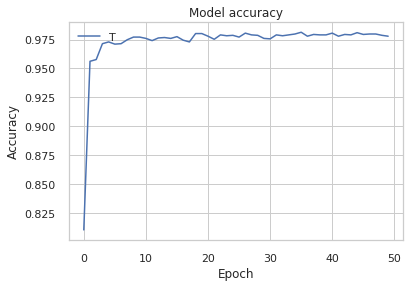

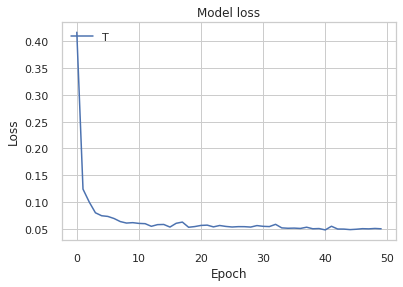

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

# # Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

In [38]:
predicted = model.predict(X_test)
predicted = (predicted > 0.5)
predicted

array([[False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [

In [39]:
from yellowbrick.classifier import ConfusionMatrix

In [40]:
mapping = { 0: 'Non-IoT', 1: 'IoT'}

In [41]:
cm_viz = ConfusionMatrix(model, classes=['Non-IoT','IoT'], label_encoder=mapping)

YellowbrickTypeError: This estimator is not a classifier; try a regression or clustering score visualizer instead!